<a href="https://colab.research.google.com/github/LiorKlunover/Microsoft-Stock-Forecasting-with-LSTMs/blob/main/Microsoft%20Stock%20Forecasting%20with%20LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

In [ ]:
ticker = 'MSFT'
msft_data = yf.Ticker(ticker)
historical_data = msft_data.history(period="max")

In [ ]:
historical_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,0.054485,0.062498,0.054485,0.059827,1031788800,0.0,0.0
1986-03-14 00:00:00-05:00,0.059827,0.063032,0.059827,0.061963,308160000,0.0,0.0
1986-03-17 00:00:00-05:00,0.061963,0.063566,0.061963,0.063032,133171200,0.0,0.0
1986-03-18 00:00:00-05:00,0.063032,0.063566,0.060895,0.061429,67766400,0.0,0.0
1986-03-19 00:00:00-05:00,0.061429,0.061963,0.059827,0.060361,47894400,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-29 00:00:00-05:00,420.089996,424.880005,417.799988,423.459991,16271900,0.0,0.0
2024-12-02 00:00:00-05:00,421.570007,433.000000,421.309998,430.980011,20207200,0.0,0.0
2024-12-03 00:00:00-05:00,429.839996,432.470001,427.739990,431.200012,18302000,0.0,0.0


<Axes: title={'center': 'Microsoft Stock Price History'}, xlabel='Date'>

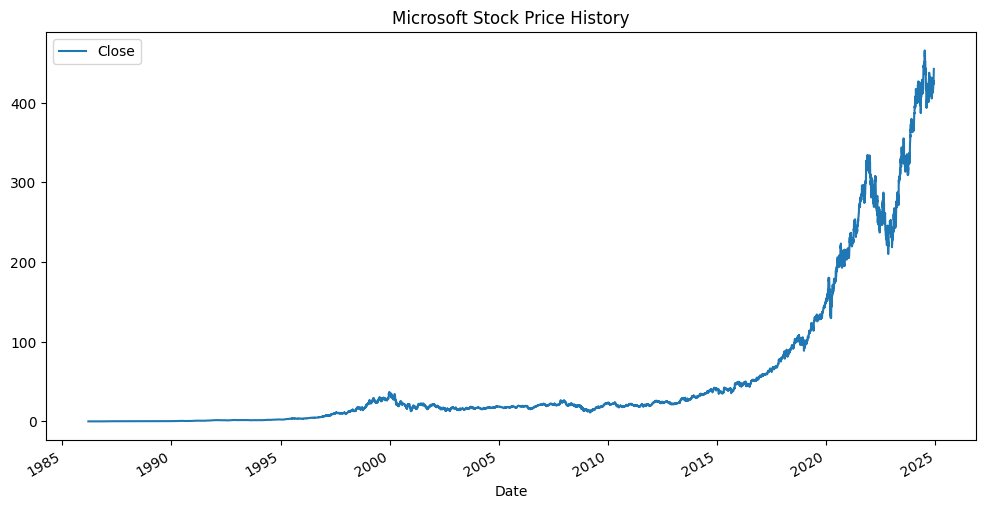

In [ ]:
# Plot the closing price over time
y = historical_data[['Close']]
y.plot(figsize=(12, 6), title="Microsoft Stock Price History")

In [ ]:
# Keep only the 'Close' column and reset the index, keeping the original 'Date'
df = historical_data[['Close']].reset_index()  # 'Date' is create

# Create lagged columns
df['Close - 3 days'] = df['Close'].shift(3)
df['Close - 2 days'] = df['Close'].shift(2)
df['Close - 1 day']  = df['Close'].shift(1)

# Drop rows with NaN values caused by shifting
df = df.dropna()

# Reorganize the columns
df = df[['Date', 'Close - 3 days', 'Close - 2 days', 'Close - 1 day', 'Close']]

df

,Date,Close - 3 days,Close - 2 days,Close - 1 day,Close
3,1986-03-18 00:00:00-05:00,0.059827,0.061963,0.063032,0.061429
4,1986-03-19 00:00:00-05:00,0.061963,0.063032,0.061429,0.060361
5,1986-03-20 00:00:00-05:00,0.063032,0.061429,0.060361,0.058758
6,1986-03-21 00:00:00-05:00,0.061429,0.060361,0.058758,0.057156
7,1986-03-24 00:00:00-05:00,0.060361,0.058758,0.057156,0.055554
...,...,...,...,...,...
9757,2024-11-29 00:00:00-05:00,418.790009,427.989990,422.989990,423.459991
9758,2024-12-02 00:00:00-05:00,427.989990,422.989990,423.459991,430.980011
9759,2024-12-03 00:00:00-05:00,422.989990,423.459991,430.980011,431.200012
9760,2024-12-04 00:00:00-05:00,423.459991,430.980011,431.200012,437.420013


In [ ]:
#converting to numpy array + cutting the data
dates = df['Date'].values
features = df.drop(['Date', 'Close'], axis=1).values
target_column = df['Close'].values


# Normalize the data
scaler = MinMaxScaler()
features_scaled  = scaler.fit_transform(features)
target_scaled = scaler.fit_transform(target_column.reshape(-1, 1))

# Reshape data for RNN (samples, timesteps, features)
X = features_scaled .reshape(features_scaled .shape[0], features_scaled .shape[1], 1)
y = target_scaled

In [ ]:
# Step 2: Split data into training, validation, and test sets
# Define split ratios
train_size = int(len(X) * 0.7)  # 70% for training
valid_size = int(len(X) * 0.15)  # 15% for validation
test_size = len(X) - train_size - valid_size  # Remaining 15% for testing

# Slicing the data
X_train, X_valid, X_test = X[:train_size], X[train_size:train_size + valid_size], X[train_size + valid_size:]
y_train, y_valid, y_test = y[:train_size], y[train_size:train_size + valid_size], y[train_size + valid_size:]
d_train, d_valid, d_test = dates[:train_size], dates[train_size:train_size + valid_size], dates[train_size + valid_size:]

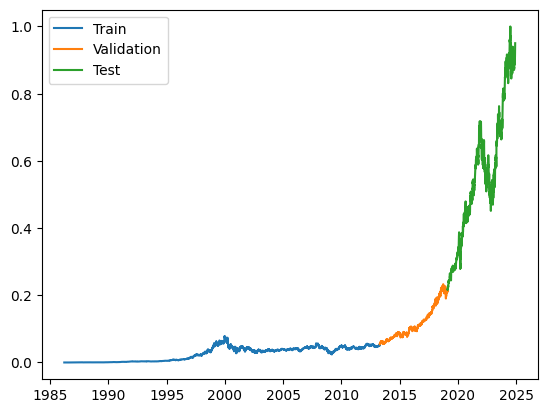

In [ ]:
plt.plot(d_train,y_train)
plt.plot(d_valid,y_valid)
plt.plot(d_test,y_test)
plt.legend(['Train', 'Validation', 'Test'])

In [ ]:


#%%
# Step 3: Build the 3-layer RNN model
model = Sequential()
# First RNN layer
model.add(SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(X.shape[1], X.shape[2])))

# Second RNN layer
model.add(SimpleRNN(50, activation='relu', return_sequences=True))

# Third RNN layer
model.add(SimpleRNN(50, activation='relu'))

# Output layer
model.add(Dense(1))

# Step 4: Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Step 5: Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_valid, y_valid)
)

Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 7.3279e-05 - mae: 0.0034 - val_loss: 5.4585e-05 - val_mae: 0.0050
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.1131e-07 - mae: 6.4975e-04 - val_loss: 5.8548e-05 - val_mae: 0.0050
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0970e-06 - mae: 7.7157e-04 - val_loss: 6.6018e-05 - val_mae: 0.0055
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.2105e-07 - mae: 6.6232e-04 - val_loss: 1.1686e-04 - val_mae: 0.0082
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1062e-06 - mae: 7.6900e-04 - val_loss: 7.8409e-05 - val_mae: 0.0060
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.6831e-07 - mae: 7.0152e-04 - val_loss: 9.3631e-05 - val_mae: 0.0068
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 9.6773e-07 - mae: 7.1447e-04 - val_loss: 1.5133e-04 - val_mae: 0.0092
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0338e-06 - mae: 7.4003e-04 - val

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


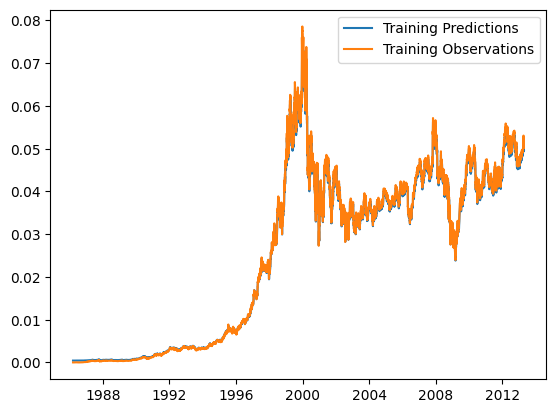

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(d_train, train_predictions)
plt.plot(d_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


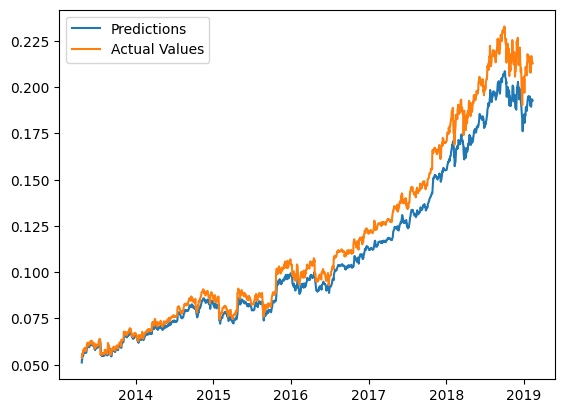

In [ ]:
# Step 7: Make predictions (optional)
valid_pred = model.predict(X_valid).flatten()

plt.plot(d_valid, valid_pred)
plt.plot(d_valid, y_valid)
plt.legend(['Predictions', 'Actual Values'])

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


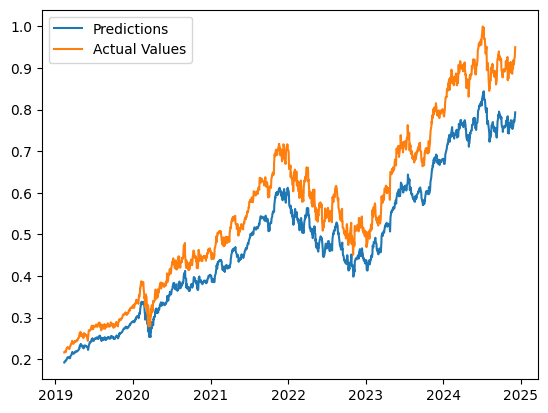

In [ ]:
test_pred = model.predict(X_test).flatten()

plt.plot(d_test, test_pred)
plt.plot(d_test, y_test)
plt.legend(['Predictions', 'Actual Values'])